# Network Analysis - Indian Railways

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
schedule_df = pd.read_csv('datasets_railways\dataset.csv')

### Dataset description

In [3]:
schedule_df.head()

,Train No,Train Name,SEQ,Station Code,Station Name,Arrival time,Departure Time,Distance,Source Station,Source Station Name,Destination Station,Destination Station Name
0,107,SWV-MAO-VLNK,1,SWV,SAWANTWADI R,00:00:00,10:25:00,0,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
1,107,SWV-MAO-VLNK,2,THVM,THIVIM,11:06:00,11:08:00,32,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
2,107,SWV-MAO-VLNK,3,KRMI,KARMALI,11:28:00,11:30:00,49,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
3,107,SWV-MAO-VLNK,4,MAO,MADGOAN JN.,12:10:00,00:00:00,78,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
4,108,VLNK-MAO-SWV,1,MAO,MADGOAN JN.,00:00:00,20:30:00,0,MAO,MADGOAN JN.,SWV,SAWANTWADI ROAD


### Checking null values and dropping them

In [4]:
schedule_df.isnull().sum()

Train No                     0
Train Name                   0
SEQ                          0
Station Code                 0
Station Name                 0
Arrival time                 5
Departure Time               5
Distance                     5
Source Station              10
Source Station Name         10
Destination Station         10
Destination Station Name    10
dtype: int64

In [5]:
schedule_df = schedule_df.dropna()
schedule_df.dtypes

Train No                    object
Train Name                  object
SEQ                         object
Station Code                object
Station Name                object
Arrival time                object
Departure Time              object
Distance                    object
Source Station              object
Source Station Name         object
Destination Station         object
Destination Station Name    object
dtype: object

### Finding total number of unique source and destination stations 

In [15]:
print(f"Unique Source Stations: {schedule_df['Source Station Name'].nunique()}")
print(f"Unique Destination Stations: {schedule_df['Destination Station Name'].nunique()}")

Unique Source Stations: 921
Unique Destination Stations: 923


### Distribution of Distance between Stations

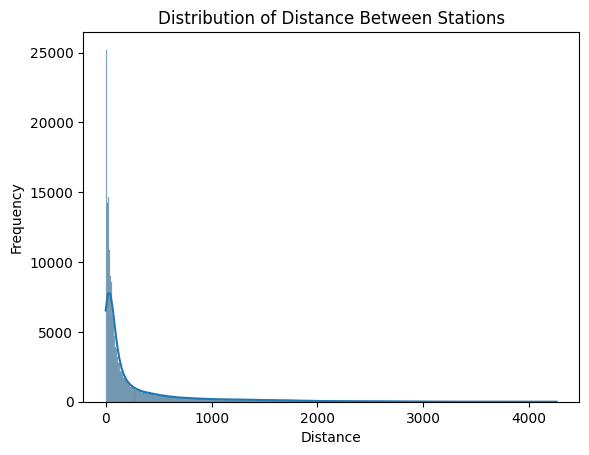

<Figure size 1200x600 with 0 Axes>

In [16]:
schedule_df['Distance'] = pd.to_numeric(schedule_df['Distance'], errors='coerce')

sns.histplot(schedule_df['Distance'], kde=True)
plt.title('Distribution of Distance Between Stations')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.figure(figsize=(12, 6)) 
plt.show()

### Function to create the railway network

The network was created with the following parameters:

- Source (Trains origin source station)
- Destination (Trains reaching destination station)
- Weights (Number of trains between source and destination stations)

The network was created by keeping in mind, to measure the busyness of each of the stations in the Indian Railways Network.

In [6]:
def create_railway_network(data, specific_stations=None):
    network = nx.DiGraph()
    
    if specific_stations is None:
        stations = np.unique(data['Station Code'])
    else:
        stations = specific_stations
    
    network.add_nodes_from(stations)
    
    for each_train in data['Train Name'].unique():
        
        route_data = data[data['Train Name'] == each_train]
        route_stations = route_data['Station Code'].tolist()
        
        for start in range(len(route_stations)):
            for end in range(start + 1, len(route_stations)):
                start_station = route_stations[start]
                end_station = route_stations[end]
                
                if stations is None or start_station in stations or end_station in stations:
                    distance = 1
                    if network.has_edge(start_station, end_station):
                        network[start_station][end_station]['weight'] += distance
                    else:
                        network.add_edge(start_station, end_station, weight=distance)

    return network

In [7]:
try:
    with open('datasets_railways/train_count_network.gpickle', 'rb') as f:
        railway_network = pickle.load(f)
except:
    railway_network = create_railway_network(schedule_df)
    with open("datasets_railways/train_count_network_new.gpickle", 'wb') as f:
        pickle.dump(railway_network, f, pickle.HIGHEST_PROTOCOL)

In [8]:
print('Number of nodes', len(railway_network.nodes))
print('Number of edges', len(railway_network.edges))
print('Average in-degree', sum(d for n, d in railway_network.in_degree()) / railway_network.number_of_nodes())
print('Average out-degree', sum(d for n, d in railway_network.out_degree()) / railway_network.number_of_nodes())

Number of nodes 8147
Number of edges 902602
Average in-degree 110.78949306493188
Average out-degree 110.78949306493188


### Top Nodes by degree

In [10]:
def find_top_nodes_by_degree(graph, top_n=10):
    degrees = graph.degree()
    top_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)[:top_n]
    return top_nodes

In [11]:
find_top_nodes_by_degree(railway_network)

[('HWH', 2461),
 ('BZA', 2203),
 ('CNB', 2149),
 ('BSB', 2099),
 ('GZB', 2053),
 ('KYN', 2020),
 ('ET', 1991),
 ('LKO', 1985),
 ('ADI', 1943),
 ('MTJ', 1925)]

### Function to extract and visualize the subgraphs

In [17]:
def extract_and_visualize_subgraph(train_data, main_graph, query_nodes):
    directed_subgraph = nx.DiGraph()

    for start_index in range(len(query_nodes)):
        for end_index in range(start_index + 1, len(query_nodes)):
            pairwise_subgraph = create_railway_network(train_data, [query_nodes[start_index], query_nodes[end_index]])
            directed_subgraph = nx.compose(directed_subgraph, pairwise_subgraph)

    undirected_subgraph = directed_subgraph.to_undirected()
    plt.figure(figsize=(10, 10), facecolor='yellow')  
    layout = nx.fruchterman_reingold_layout(undirected_subgraph)  
    nx.draw(undirected_subgraph, layout, node_color='green', node_size=350, edge_color='black')

    set_path = set()
    set_nodes = set()
    for i in range(len(query_nodes)):
        for j in range(i + 1, len(query_nodes)):
            try:
                shortest_path = nx.shortest_path(main_graph, source=query_nodes[i], target=query_nodes[j])
                for k in range(len(shortest_path) - 1):
                    set_path.add((shortest_path[k], shortest_path[k + 1]))
                set_nodes.update(shortest_path)
            except nx.NetworkXNoPath:
                print(f"Path does not exist between {query_nodes[i]} and {query_nodes[j]}")

    nx.draw_networkx_nodes(undirected_subgraph, layout, nodelist=set_nodes, node_color='green')
    nx.draw_networkx_nodes(undirected_subgraph, layout, nodelist=query_nodes, node_color='red', node_size=700)
    nx.draw_networkx_edges(undirected_subgraph, layout, edgelist=set_path, edge_color='black', width=2)
    nx.draw_networkx_labels(undirected_subgraph, layout, font_size=5, font_color='yellow')

    plt.axis('on') 
    plt.title(f'Fruchterman Reingold Layout for the subgraph of {query_nodes[0]} to {query_nodes[1]}')
    plt.show()

    return undirected_subgraph

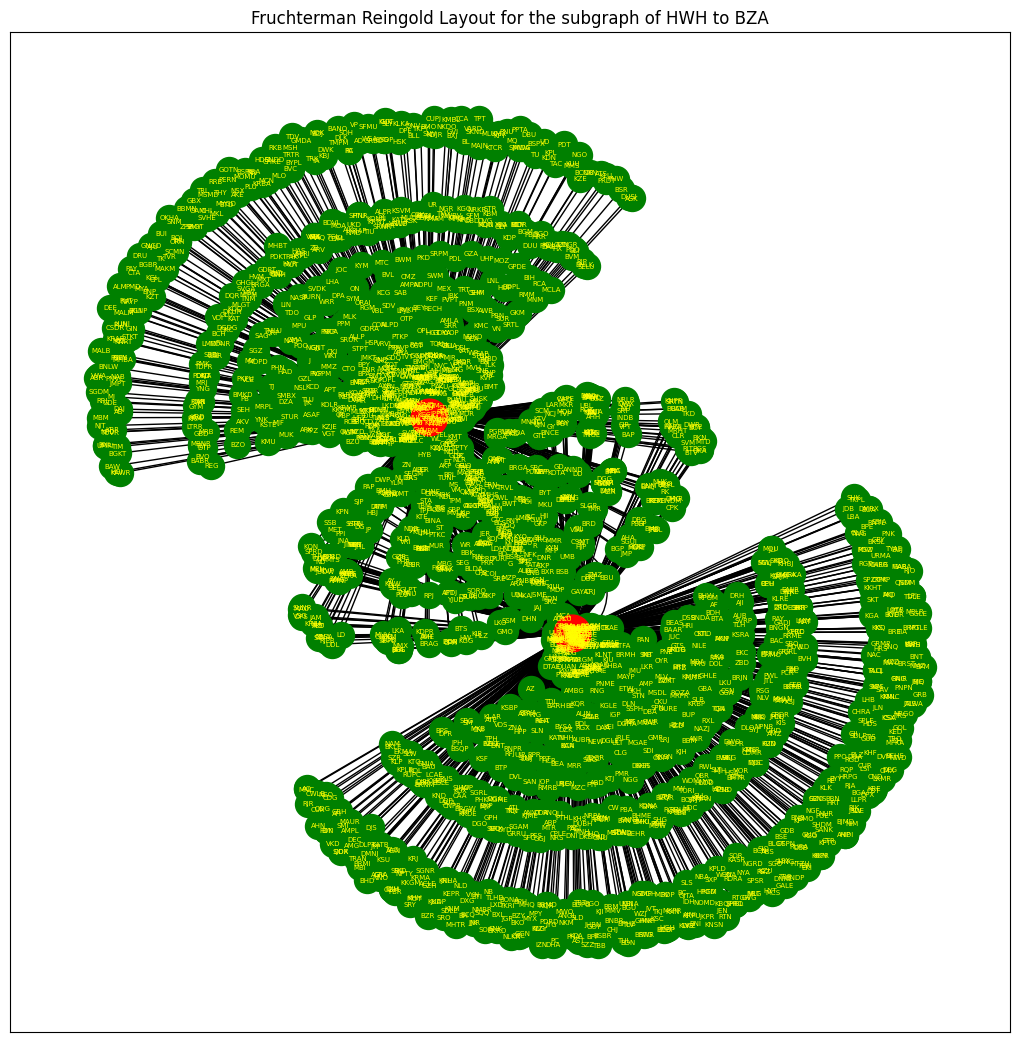

In [18]:
subgraph = extract_and_visualize_subgraph(schedule_df, railway_network, ['HWH', 'BZA'])

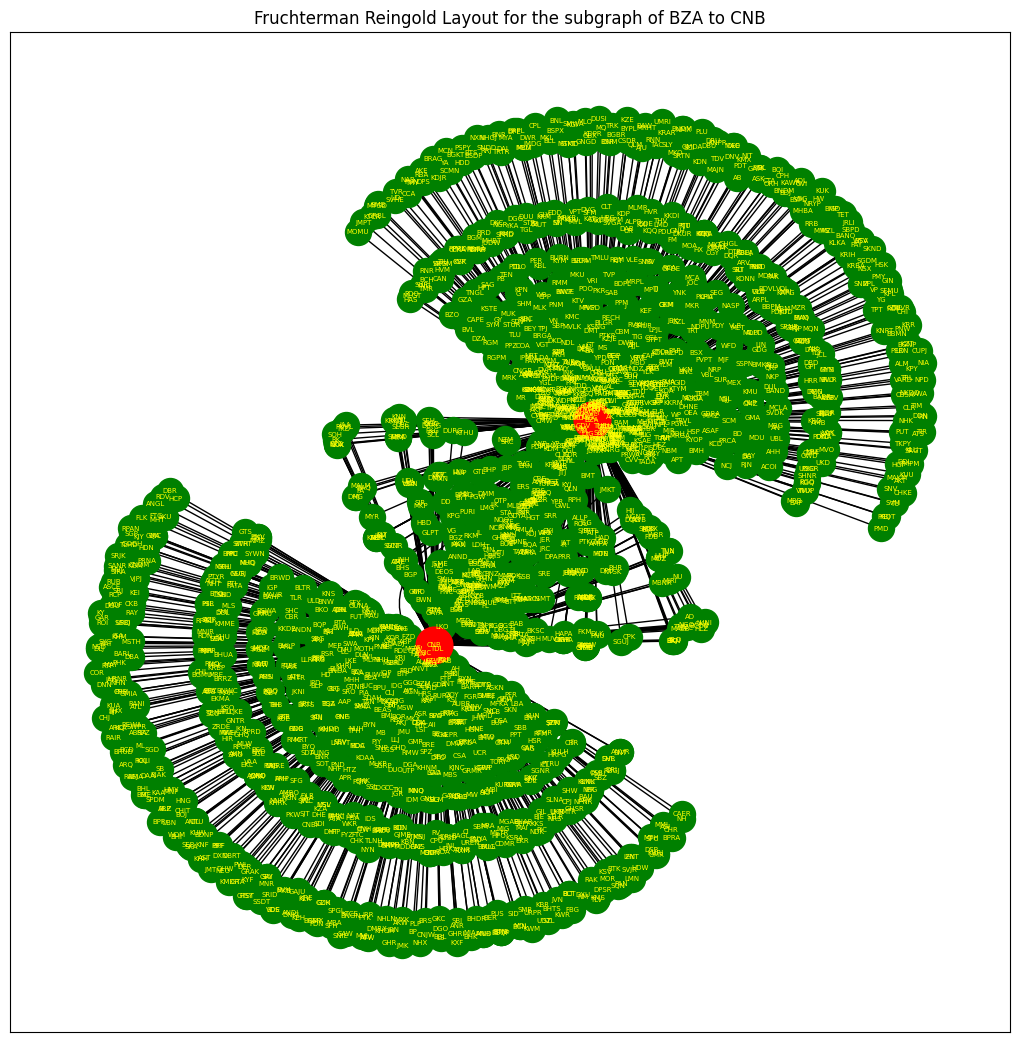

In [50]:
subgraph = extract_and_visualize_subgraph(schedule_df, railway_network, ['BZA', 'CNB'])

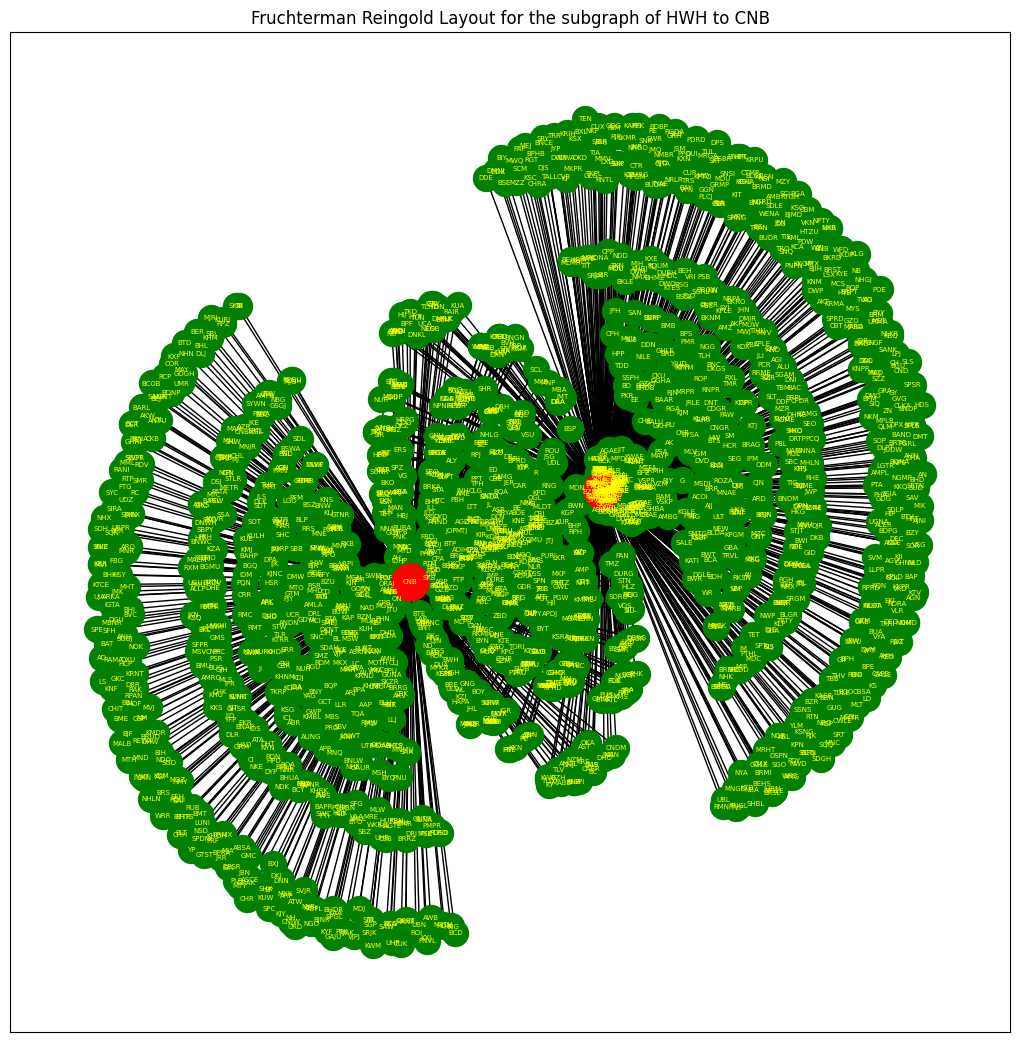

In [51]:
subgraph = extract_and_visualize_subgraph(schedule_df, railway_network, ['HWH', 'CNB'])

### Computing Network Metrics

In [12]:
def compute_network_metrics(graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    clustering_coefficients = nx.clustering(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)

    degree_df = pd.DataFrame(degree_centrality.items(), columns=['Node', 'Degree Centrality'])
    betweenness_df = pd.DataFrame(betweenness_centrality.items(), columns=['Node', 'Betweenness Centrality'])
    closeness_df = pd.DataFrame(closeness_centrality.items(), columns=['Node', 'Closeness Centrality'])
    clustering_df = pd.DataFrame(clustering_coefficients.items(), columns=['Node', 'Clustering Coefficient'])
    eigenvector_df = pd.DataFrame(eigenvector_centrality.items(), columns=['Node', 'Eigenvector Centrality'])

    merged_df = degree_df.merge(betweenness_df, on='Node') \
                        .merge(closeness_df, on='Node') \
                        .merge(clustering_df, on='Node') \
                        .merge(eigenvector_df, on='Node')
    
    merged_df.sort_values('Degree Centrality', ascending=False, inplace=True)

    return merged_df

In [13]:
network_metrics_path = 'datasets_railways/network_metrics.csv'

In [14]:
try:
    hubs = pd.read_csv(network_metrics_path)
except:
    hubs = compute_network_metrics(railway_network)
    hubs.sort_values(by='Degree Centrality', ascending=False, inplace=True)
    hubs.to_csv(network_metrics_path, index=False)

### Plotting Centralities

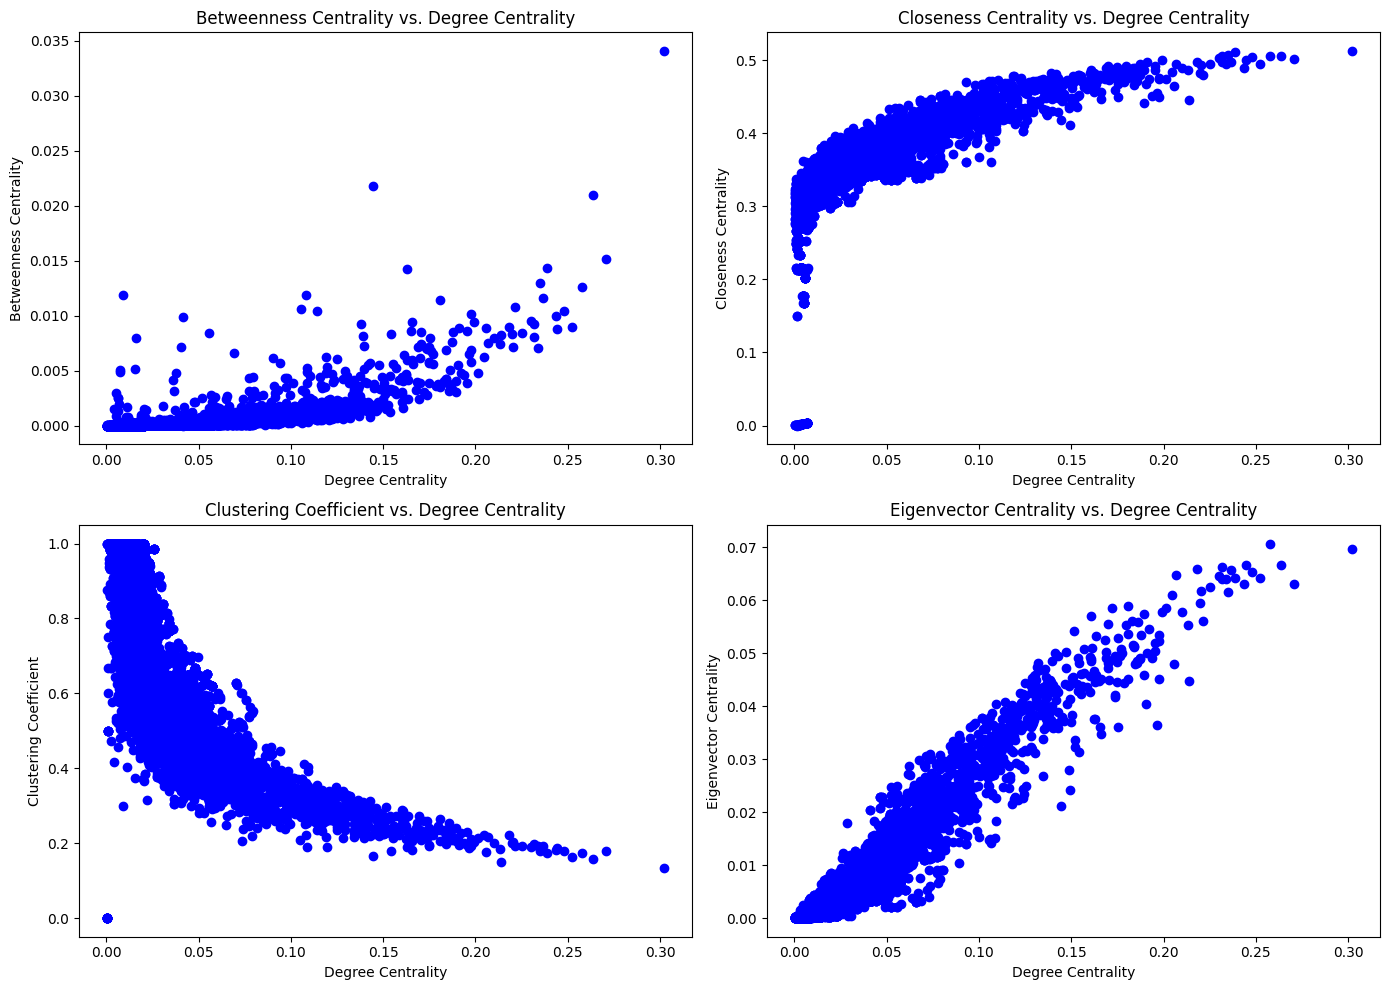

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()  

titles = [
    'Betweenness Centrality vs. Degree Centrality',
    'Closeness Centrality vs. Degree Centrality',
    'Clustering Coefficient vs. Degree Centrality',
    'Eigenvector Centrality vs. Degree Centrality'
]

columns = ['Betweenness Centrality', 'Closeness Centrality', 'Clustering Coefficient', 'Eigenvector Centrality']

for ax, col, title in zip(axes, columns, titles):
    ax.scatter(hubs['Degree Centrality'], hubs[col], color='blue')
    ax.set_title(title)
    ax.set_xlabel('Degree Centrality')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


### Plotting Average Clustering Coefficient vs Degree Centrality

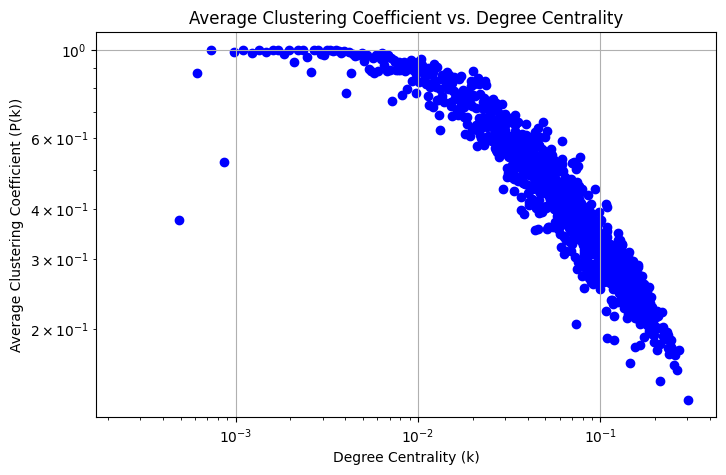

In [8]:
grouped_data = hubs.groupby('Degree Centrality')['Clustering Coefficient'].mean()

plt.figure(figsize=(8, 5))
plt.scatter(grouped_data.index, grouped_data.values, color='blue')
plt.xscale('log')  
plt.yscale('log')  
plt.xlabel('Degree Centrality (k)')
plt.ylabel('Average Clustering Coefficient (P(k))')
plt.title('Average Clustering Coefficient vs. Degree Centrality')
plt.grid(True)
plt.show()

## Finding Top 10 Nodes according to each Centrality Measure

### 1. Degree Centrality

In [21]:
def degree_centrality(graph):
    try:
        network_metrics = pd.read_csv(network_metrics_path)
    except FileNotFoundError:
        network_metrics = compute_network_metrics(graph)
        network_metrics.to_csv(network_metrics_path, index=False)

    network_metrics.sort_values(by='Degree Centrality', ascending=False, inplace=True)
    
    return network_metrics[['Node', 'Degree Centrality']].head(10)

In [22]:
top10_degree_centrality = degree_centrality(railway_network)
top10_degree_centrality

,Node,Degree Centrality
0,HWH,0.302111
1,BZA,0.270439
2,CNB,0.263810
3,BSB,0.257672
4,GZB,0.252026
5,KYN,0.247974
6,ET,0.244414
7,LKO,0.243678
8,ADI,0.238522
9,MTJ,0.236312


### 2. Betweenness Centrality

In [23]:
def betweenness_centrality(graph):
    try:
        network_metrics = pd.read_csv(network_metrics_path)
    except FileNotFoundError:
        network_metrics = compute_network_metrics(graph)
        network_metrics.to_csv(network_metrics_path, index=False)

    network_metrics.sort_values(by='Betweenness Centrality', ascending=False, inplace=True)
    return network_metrics[['Node', 'Betweenness Centrality']].head(10)

In [24]:
top10_betweenness_centrality = betweenness_centrality(railway_network)
top10_betweenness_centrality

,Node,Betweenness Centrality
0,HWH,0.034064
123,SDAH,0.021795
2,CNB,0.020931
1,BZA,0.015177
8,ADI,0.014302
82,YPR,0.014257
10,BRC,0.012968
3,BSB,0.012624
295,KOAA,0.011898
5684,PBE,0.011845


### 2. Closeness Centrality

In [25]:
def closeness_centrality(graph):
    try:
        network_metrics = pd.read_csv(network_metrics_path)
    except FileNotFoundError:
        network_metrics = compute_network_metrics(graph)
        network_metrics.to_csv(network_metrics_path, index=False)

    network_metrics.sort_values(by='Closeness Centrality', ascending=False, inplace=True)
    return network_metrics[['Node', 'Closeness Centrality']].head(10)

In [26]:
top10_closeness_centrality = closeness_centrality(railway_network)
top10_closeness_centrality

,Node,Closeness Centrality
0,HWH,0.512408
8,ADI,0.510766
10,BRC,0.506352
2,CNB,0.506288
3,BSB,0.505229
13,NDLS,0.505197
5,KYN,0.503664
14,MGS,0.503505
1,BZA,0.502141
6,ET,0.499810


### 4. Eigenvector Centrality

In [46]:
def eigenvector_centrality(graph):
    try:
        network_metrics = pd.read_csv(network_metrics_path)
    except FileNotFoundError:
        network_metrics = compute_network_metrics(graph)
        network_metrics.to_csv(network_metrics_path, index=False)

    network_metrics.sort_values(by='Eigenvector Centrality', ascending=False, inplace=True)
    return network_metrics[['Node', 'Eigenvector Centrality']].head(10)

In [47]:
top10_eigenvector_centrality = eigenvector_centrality(railway_network)
top10_eigenvector_centrality

,Node,Eigenvector Centrality
3,BSB,0.070716
0,HWH,0.069651
2,CNB,0.066752
6,ET,0.066749
13,NDLS,0.066240
19,LDH,0.065925
9,MTJ,0.065690
5,KYN,0.065274
23,PNBE,0.064723
14,MGS,0.064570


### Plotting Degree Distribution

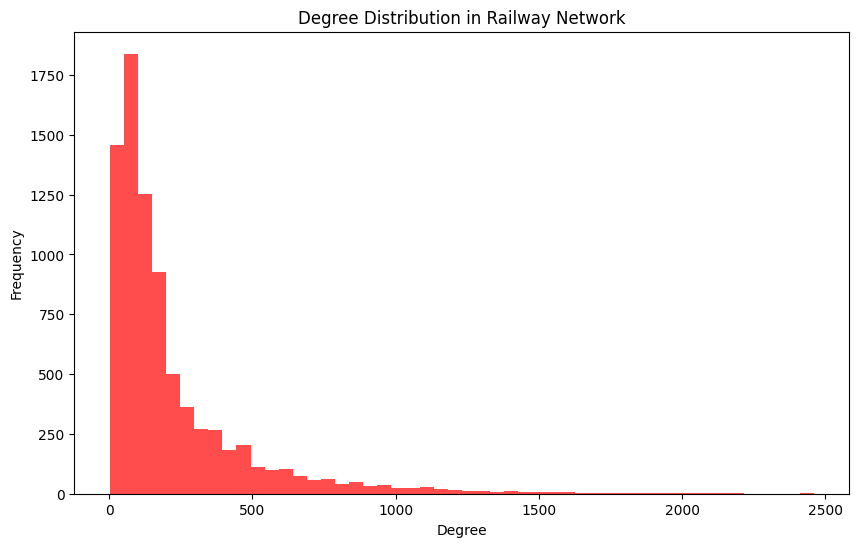

In [45]:
degree_sequence = [d for n, d in railway_network.degree()]

plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.hist(degree_sequence, bins=50, color='red', alpha=0.7)  # Histogram with 50 bins
plt.title("Degree Distribution in Railway Network")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.grid(False)
plt.show()

### Degree Distribution Log-Log Plot

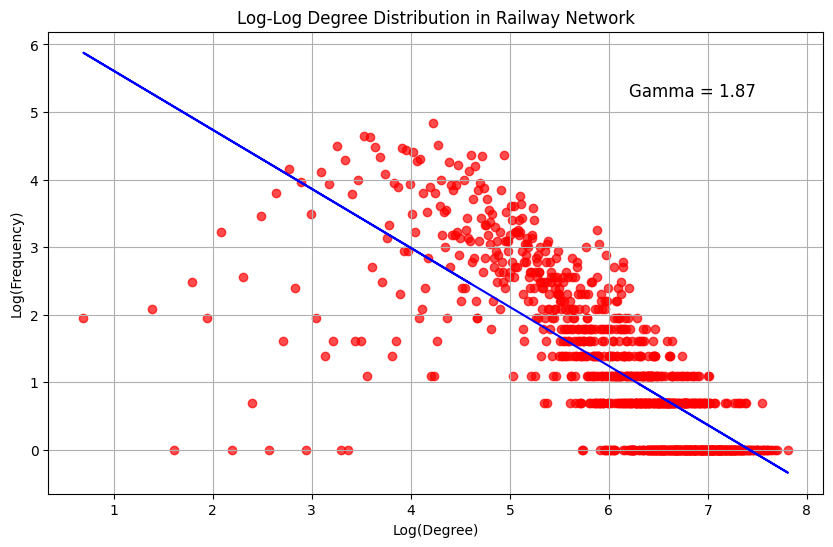

In [25]:
degree_sequence = [d for n, d in railway_network.degree()]

degree_counts = {}
for degree in degree_sequence:
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

degrees = list(degree_counts.keys())
frequencies = [degree_counts[d] for d in degrees]

log_degrees = np.log(degrees)
log_frequencies = np.log(frequencies)

slope, intercept = np.polyfit(log_degrees, log_frequencies, 1)

plt.figure(figsize=(10, 6))
plt.scatter(log_degrees, log_frequencies, color='red', alpha=0.7)  # Scatter plot of log-log data
plt.plot(log_degrees, slope * log_degrees + intercept, color='blue')  # Line of best fit

gamma = -slope
plt.text(0.75, 0.89, f'Gamma = {gamma+1.0:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title("Log-Log Degree Distribution in Railway Network")
plt.ylabel("Log(Frequency)")
plt.xlabel("Log(Degree)")
plt.grid(True)
plt.show()


### Clustering Coefficients

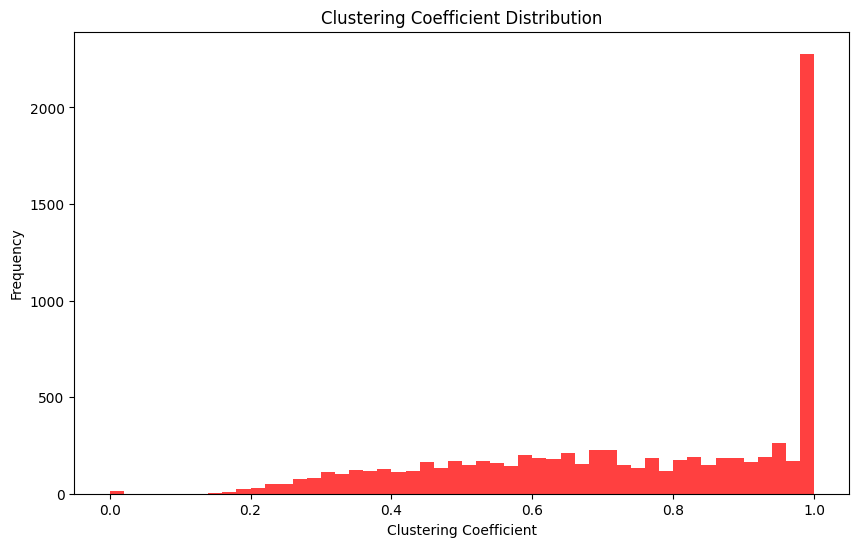

In [43]:
def plot_clustering_coefficient(graph):
    try:
        if network_metrics_path:
            data = pd.read_csv(network_metrics_path)
            clustering_coeffs = data['Clustering Coefficient']
        else:
            raise FileNotFoundError
    except FileNotFoundError:
        cc = nx.clustering(graph)
        clustering_coeffs = list(cc.values())
        
    sorted_coeffs = sorted(clustering_coeffs)
    
    plt.figure(figsize=(10, 6))
    plt.hist(sorted_coeffs, bins=50, color='red', alpha=0.75)
    plt.title("Clustering Coefficient Distribution")
    plt.xlabel("Clustering Coefficient")
    plt.ylabel("Frequency")
    plt.grid(False)
    plt.show()


plot_clustering_coefficient(railway_network)

## Plotting Centralities

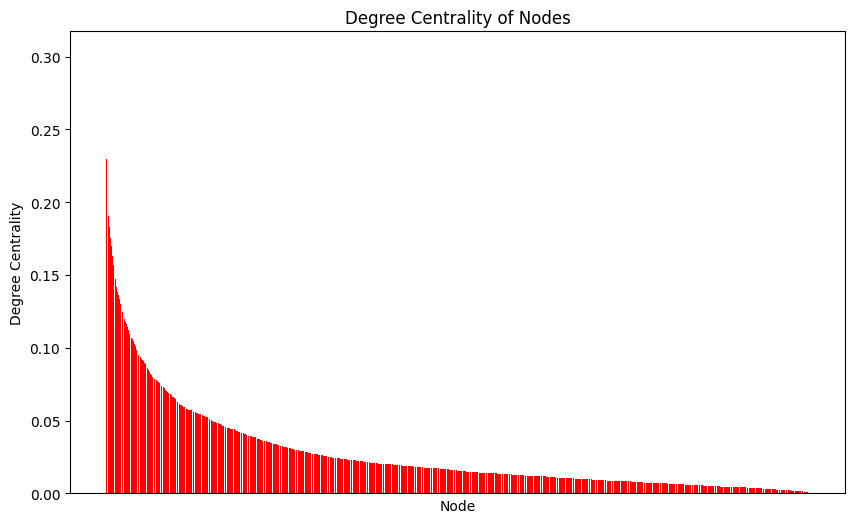

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(hubs['Node'], hubs['Degree Centrality'], color='red')
plt.xlabel('Node')
plt.ylabel('Degree Centrality')
plt.title('Degree Centrality of Nodes')
plt.xticks([])  
plt.show()


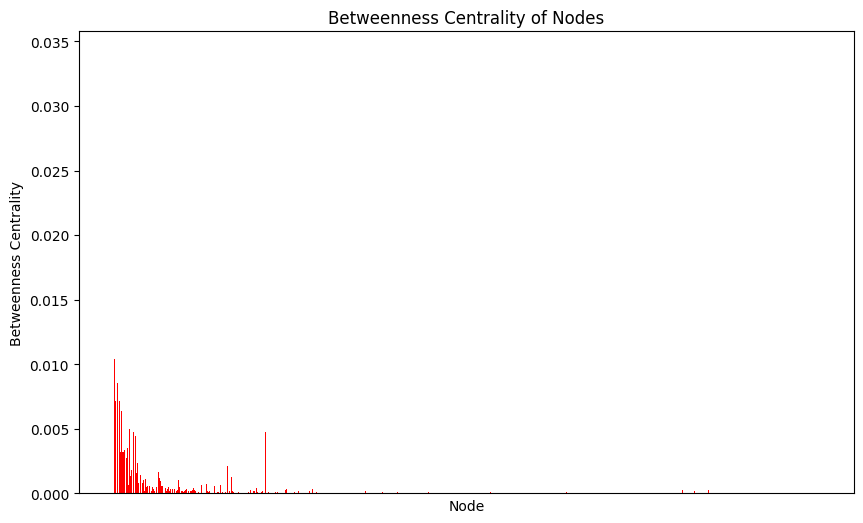

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(hubs['Node'], hubs['Betweenness Centrality'], color='red')
plt.xlabel('Node')
plt.ylabel('Betweenness Centrality')
plt.title('Betweenness Centrality of Nodes')
plt.xticks([])  # Disable xticks
plt.show()


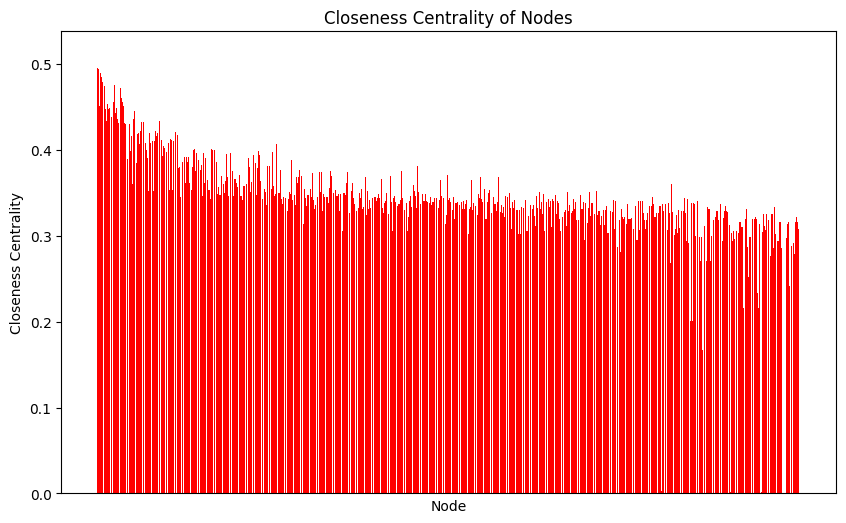

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(hubs['Node'], hubs['Closeness Centrality'], color='red')
plt.xlabel('Node')
plt.ylabel('Closeness Centrality')
plt.title('Closeness Centrality of Nodes')
plt.xticks([]) 
plt.show()


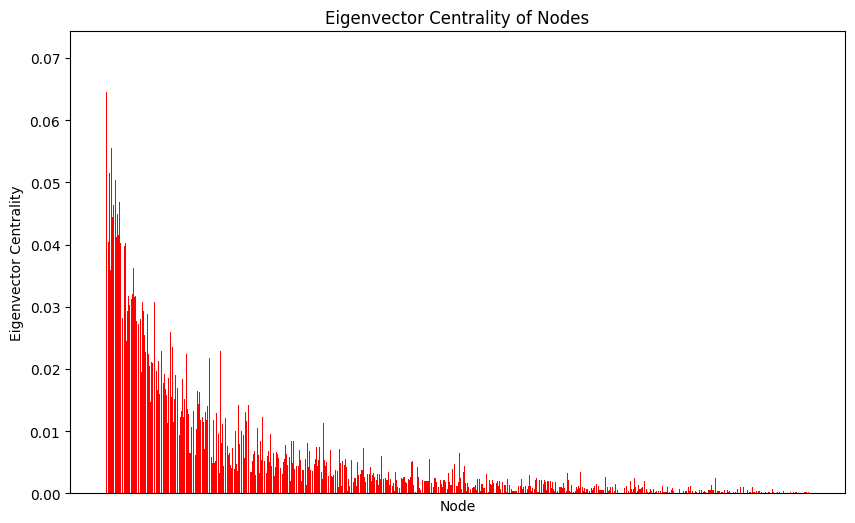

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(hubs['Node'], hubs['Eigenvector Centrality'], color='red')
plt.xlabel('Node')
plt.ylabel('Eigenvector Centrality')
plt.title('Eigenvector Centrality of Nodes')
plt.xticks([]) 
plt.show()
